In [1]:
import pandas as pd
from astropy.time import Time
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

In [3]:
cycle2 = pd.read_csv('tess_cycle_2_prediction.dat')

In [5]:
dt = 14

In [28]:
# Get the dat from SkyBot (~ 10 minutes)
for field in range(len(cycle2)):
    for camera in tqdm([1, 2, 3, 4], desc='Sector {}'.format(field)):
        output_fn = f'catalog/sector{field}-camera{camera}.hf5'
        epoch =  Time(datetime.strptime(cycle2.Start[field], '%m/%d/%y')).jd + dt
        sector = cycle2[f'Sector'][field]
        ra = cycle2[f'Cam{camera}RA'][field]
        dec = cycle2[f'Cam{camera}Dec'][field]
        crd = SkyCoord(ra, dec, frame='icrs', unit='deg')
        radius = 36
        location = '000'

        url = 'http://vo.imcce.fr/webservices/skybot/skybotconesearch_query.php?'
        url += '-mime=text&'
        url += '-ra={}&'.format(ra)
        url += '-dec={}&'.format(dec)
        url += '-bd={}&'.format(radius)
        url += '-loc={}&'.format(location)
        url += 'EPOCH={}'.format(epoch)

        res = pd.read_csv(url, delimiter='|', skiprows=2)
        res.columns = [r.replace('#', '').strip() for r in res.columns]
#       res1 = res1[res1.Mv < 18]
        res['epoch'] = epoch

        res.to_hdf(output_fn, key='asteroids')
#        break
#    break


Sector 0:   0%|          | 0/4 [00:00<?, ?it/s]
Exception in thread Thread-27:
Traceback (most recent call last):
  File "/Users/ch/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ch/miniconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ch/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Sector 12: 100%|██████████| 4/4 [00:45<00:00, 11.31s/it]


In [ ]:
res

In [34]:
# Create catalog
result = None
for field in tqdm(range(len(cycle2))):
    for camera in [1, 2, 3, 4]:
        ra = cycle2[f'Cam{camera}RA'][field]
        dec = cycle2[f'Cam{camera}Dec'][field]
        df = pd.read_hdf(f'catalog/sector{field}-camera{camera}.hf5')
        if len(df) == 0:
            continue
        crd_camera = SkyCoord(ra, dec, unit='deg').barycentrictrueecliptic
        crd_asteroids = SkyCoord(df['RA(h)'], df['DE(deg)'], unit=(u.hourangle, u.deg)).barycentrictrueecliptic
        mask = ((crd_asteroids.lon.deg > (crd_camera.lon.deg - 12))
                & (crd_asteroids.lon.deg < (crd_camera.lon.deg + 12))
                & (crd_asteroids.lat.deg > (crd_camera.lat.deg - 12))
                & (crd_asteroids.lat.deg < (crd_camera.lat.deg + 12))
               )
        if result is None:
            result = df[mask]
        else:
            result = result.append(df[mask])


 15%|█▌        | 2/13 [00:07<00:40,  3.69s/it]
Exception in thread Thread-41:
Traceback (most recent call last):
  File "/Users/ch/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ch/miniconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ch/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 13/13 [00:53<00:00,  4.12s/it]


In [30]:
result.to_pickle("christina/single_time_point.p")

In [35]:
c = SkyCoord(result['RA(h)'], result['DE(deg)'], unit=(u.hourangle, u.deg))

Text(0.5,1,'Solar System Objects Brighter in TESS Cycle 2')

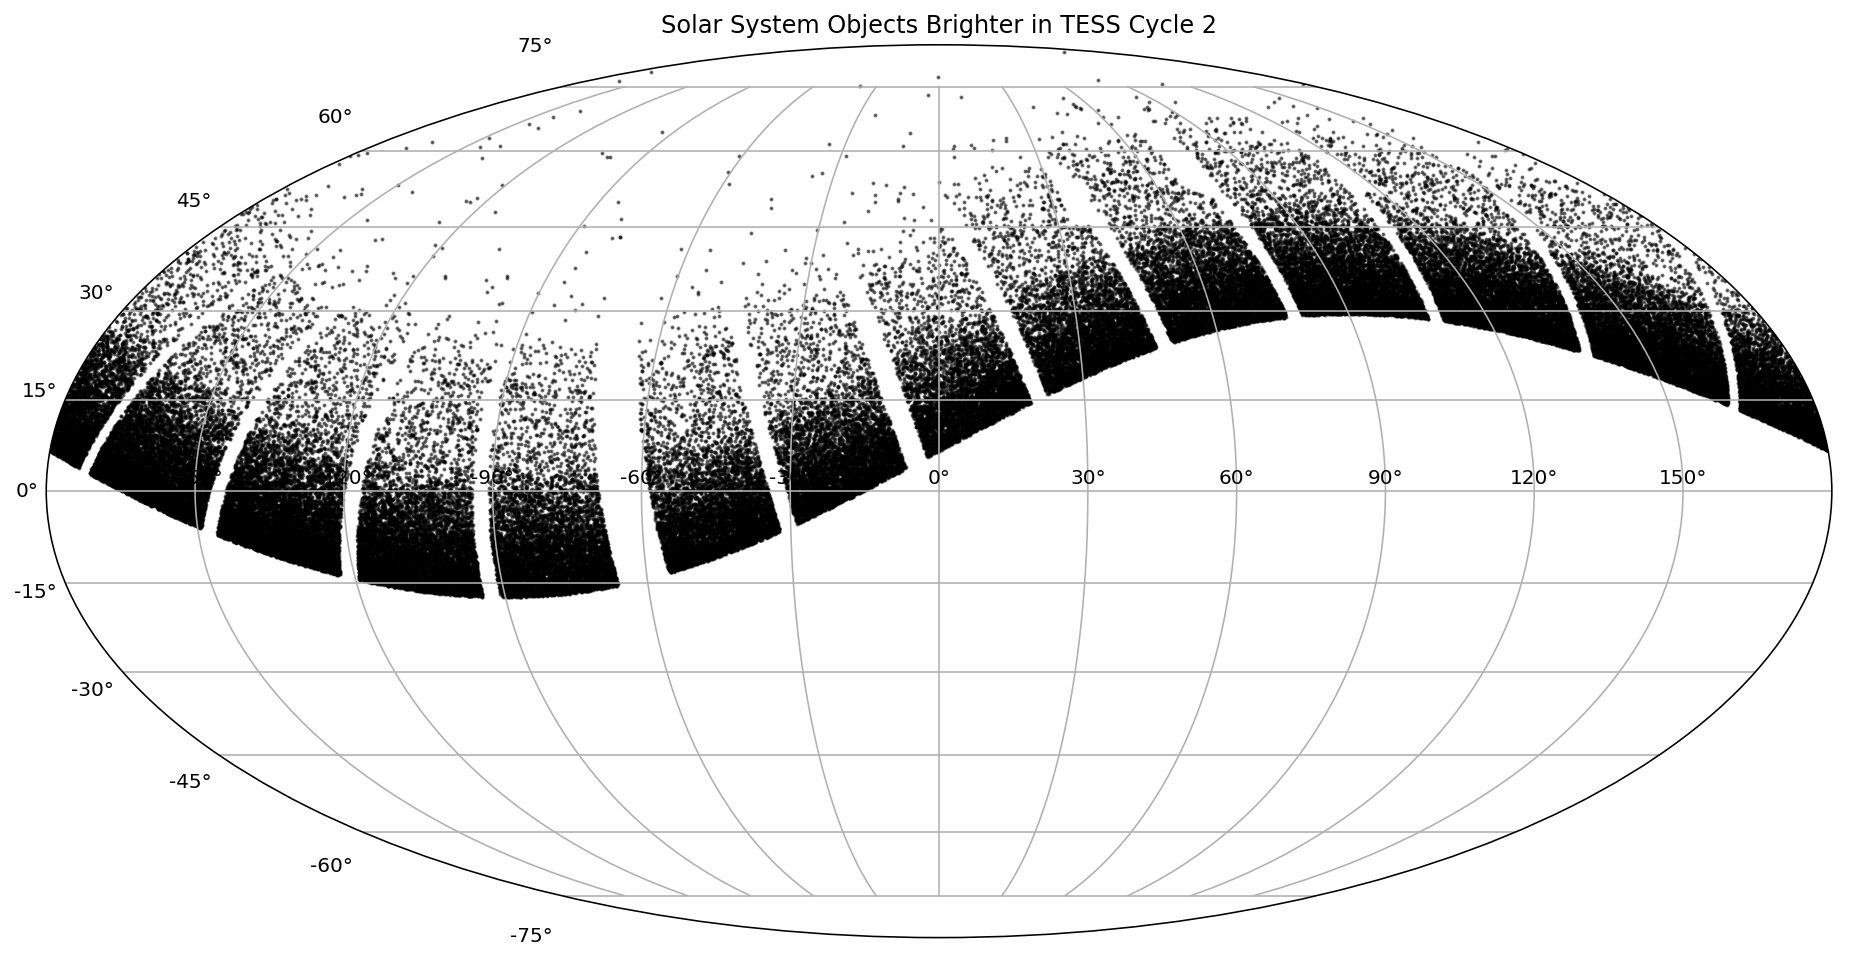

In [36]:
fig = plt.figure(figsize=(8*2, 4.2*2))
ax = plt.subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(Angle(c.ra.wrap_at(180*u.deg)).radian, Angle(c.dec).radian, c='k', alpha=0.5, s=1)
ax.set_title('Solar System Objects Brighter in TESS Cycle 2')

  0%|          | 0/13 [00:00<?, ?it/s]/Users/ch/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 85%|████████▍ | 11/13 [00:46<00:08,  4.22s/it]

KeyboardInterrupt: 

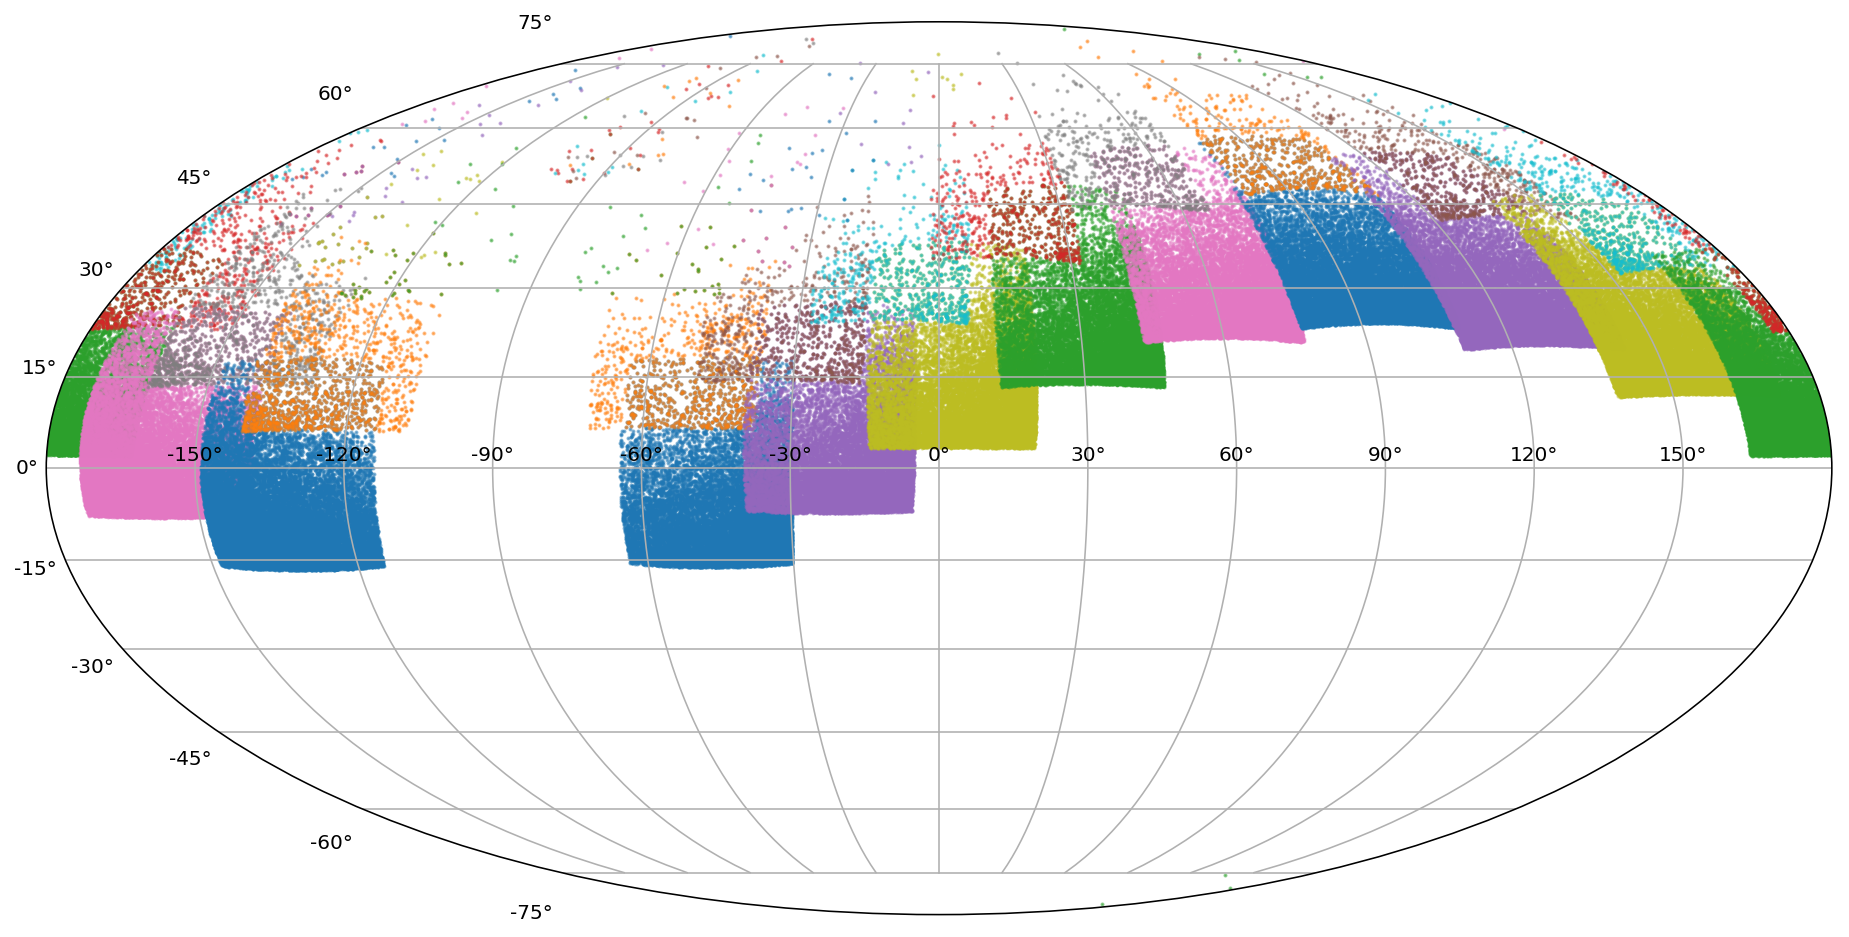

In [33]:
fig = plt.figure(figsize=(8*2, 4.2*2))

for field in tqdm(range(len(cycle2))):
    for camera in [1, 2, 3, 4]:
        result = pd.read_hdf(f'catalog/sector{field}-camera{camera}.hf5')
        if len(result) == 0:
            continue
        c = SkyCoord(result['RA(h)'], result['DE(deg)'], unit=(u.hourangle, u.deg))
        ax = plt.subplot(111, projection="mollweide")
        ax.grid(True)
        ax.scatter(Angle(c.ra.wrap_at(180*u.deg)).radian, Angle(c.dec).radian, alpha=0.5, s=1)
